In [47]:
import os
import numpy as np
from dtw import dtw
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt



In [50]:
def similarity_DTW(s1, s2):
    ratio = 50 # 设定的放缩系数，避免数据的相似度过于集中
    euclidean_norm = lambda x, y: np.abs(ratio * (x - y))
    d, cost_matrix, acc_cost_matrix, path = dtw(s1, s2, dist=euclidean_norm)
    score = 1 - np.tanh(d)  # 相似度的评分【0,1】 0： 完全不同， 1： 完全相同
    return score

DBA_cluster = np.load("./processing/DBA_wave.pkl", allow_pickle=True)
DBA_clustering_heatmap = np.zeros((len(DBA_cluster), len(DBA_cluster)))
id_list = list(DBA_cluster.keys())
for i, id in enumerate(tqdm(id_list)):
    s1 = DBA_cluster[id]
    for j in range(0, i+1):
        id_2 = id_list[j]
        s2 = DBA_cluster[id_2]
        score = similarity_DTW(s1, s2)
        DBA_clustering_heatmap[i][j] = score
        DBA_clustering_heatmap[j][i] = score

100%|██████████| 8/8 [00:00<00:00, 29.96it/s]


          0         1         2         3         4         5         6  \
0  1.000000  0.712709  0.442895  0.337285  0.004737  0.498500  0.012109   
1  0.712709  1.000000  0.297638  0.564624  0.009417  0.547687  0.010337   
2  0.442895  0.297638  1.000000  0.558302  0.011532  0.410257  0.083748   
3  0.337285  0.564624  0.558302  1.000000  0.003830  0.287923  0.013318   
4  0.004737  0.009417  0.011532  0.003830  1.000000  0.037423  0.091860   
5  0.498500  0.547687  0.410257  0.287923  0.037423  1.000000  0.109715   
6  0.012109  0.010337  0.083748  0.013318  0.091860  0.109715  1.000000   
7  0.002753  0.007191  0.003933  0.025007  0.007271  0.008200  0.001085   

          7  
0  0.002753  
1  0.007191  
2  0.003933  
3  0.025007  
4  0.007271  
5  0.008200  
6  0.001085  
7  1.000000  
[0, 2, 4, 1, 3, 7, 8, 5]
['ClusterID0', 'ClusterID2', 'ClusterID4', 'ClusterID1', 'ClusterID3', 'ClusterID7', 'ClusterID8', 'ClusterID5']
            ClusterID0  ClusterID2  ClusterID4  ClusterID1  

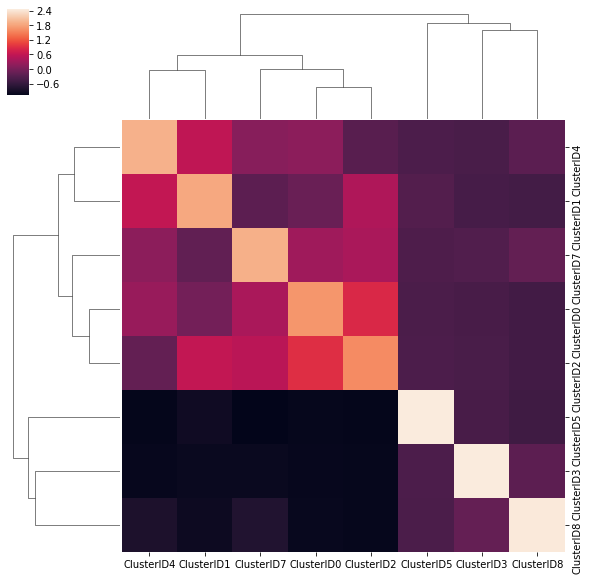

In [51]:
data_frame = pd.DataFrame(DBA_clustering_heatmap)
print(data_frame)

print(id_list)
cluster_id = ["ClusterID{}".format(x) for x in id_list]
print(cluster_id)
cluster_result = data_frame.rename(index=dict(zip(range(len(cluster_id)), cluster_id)), columns=dict(zip(range(len(cluster_id)), cluster_id)))
print(cluster_result)
# print(data_frame)

# metric数据度量方法, method计算聚类的方法
# standard_scale标准维度（0：行或1：列即每行或每列的含义，减去最小值并将每个维度除以其最大值）
# sns.clustermap(cluster_result, metric="correlation", method="single", cmap="Blues", standard_scale=1)
# sns.clustermap(cluster_result, standard_scale=1)
# Normalize 正则化
sns.clustermap(cluster_result, z_score=1)
plt.savefig("./pdf/cluster_heatmap.pdf")
plt.show()